# Filtered ICA on 1D Fields

## Preamble

### Import modules

In [1]:
"""

Import modules

"""

# %load_ext autoreload
import importlib as il
import copy

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# import matplotlib.gridspec as grd
import pickle

import scipy as sp
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal.windows import hann

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

# import nbodykit.lab as nbkt
import modules.jaafar_peaks as px
import modules.jaafar_fouriertransform as ft
import modules.jaafar_correlationfunctions as cf

import modules.fields_gauss as grf
import modules.fields_nong as nong
import modules.filters as flt
import modules.ica as ica
import modules.helpers as helper
from modules.helpers import resid

### Some technical information:

**FROM NATE:**

zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp/tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2



**Hann Window:**

w(n) = 0.5 - 0.5 * cos( (2 * pi * n) / (M-1) )     

[0 <= n <= M - 1]

## Generate Primodial $\zeta$ Fields

### Gaussian Random Fields:
<b>Set parameters and initialize the $\zeta$ GRFs.</b>

In [2]:
#
# Parameters
#
logtwo_N = 22; N = 2**logtwo_N # Field size (points/pixels)
A0 = (7.96*10**-10)# * 2*np.pi**2) # Amplitude
ns = 1.0 # Spectral tilt
# A0 = 1.0 # Amplitude
# ns = 0.965 # Spectral tilt
kmnr = 2/3 # Ratio of max (cut-off) k-freq to the Nyquist k-freq
seed1 = 741785
seed2 = 501982

#
# Generate the grfs using module gaussianfield.py --> grf
#
zg1 = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seed1)
zg2 = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seed2)

# Whether to correlate the asymsinh non-G with the GRF or not:
correlated = False
if correlated:
    zg = zg1
    seed = seed1
else:
    zg = zg2
    seed = seed2
    
# #####################
# BoxSize = 2**15
# dx = BoxSize/N
# h = 0.695
# k0 = 0.02 
# dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)
# Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3
# #####################

### Non-Gaussian Fields:
<b>Create the final, non-Gaussian $\zeta$ fields using the simulated GRF + the simulated non-G component.</b>

Note that 'zg1' is the field used to generate the NG component called 'ng_asymsinh'. 
So the 'zng_asymsinh' is correlated with 'zg1' but uncorrelated with 'zg2', a different Gaussian random field.
The final $\zeta$ field will be generated depending on the choice of 'correlation' (or lack thereof).

The 'ng_chisq' non-G component is uncorrelated to both 'zng1' and 'zng2'

#### $\Chi_e^2$ non-Gaussianity

In [3]:
#
# Parameters
#
# from nate:
# Achi = 1.6*10**(-19)
# Rchi = 0.64
# Bchi = ?
#
Achi = 10**(-10)
Rchi = 0.04
# Bchi = 10**(-13)
Bchi = 0.0
Fng = 0.7 # Instead of FNL
seedchi = 91084
seedchi = 3085
kmnr = 2/3 # Ratio of max (cut-off) k-freq to the Nyquist k-freq

#
# FINAL CHI_e^2 NON-G COMPONENT
#
#
# FINAL ZETA FIELD WITH CHI_e^2 NON-GAUSSIANITY
#
z_chisq, zng_chisq, _ = nong.nong_field_chisq(zg, Achi, Rchi, Bchi, Fng, kmnr, seedchi=seedchi)



# ng_chisq = Fng * (grf.grf_chi_1d(N, Achi, Rchi, Bchi, kmaxknyq_ratio=kmnr, seed=seedchi))**2
# ng_chisq = grf.dealiasx(ng_chisq, kmaxknyq_ratio=kmnr)
# s = np.std(ng_chisq)
# ng_chisq = (ng_chisq / s)
# ng_chisq = grf.dealiasx(ng_chisq, kmaxknyq_ratio=kmnr)
# s = np.std(ng_chisq)
# ng_chisq = (ng_chisq / s)

#### Asymmetric $\sinh$ non-Gaussianity

In [4]:
#
# Parameters
#
nu = 2
alpha = 1.0
# Other NG parameters
c, w = 2, .2
# Extract the standard deviation of the gaussian fields
s1 = zg1.std()
s2 = zg2.std()

#
# FINAL ASYMMETRIC SINH NON-G COMPONENT
#
#
# FINAL ZETA FIELD WITH ASYMMETRIC SINH NON-GAUSSIANITY
#
z_asymsinh, zng_asymsinh = nong.nong_field_asymsinh_uncorr(zg1, zg2, nu, alpha, c, w)


# ng_asymsinh = px.map_asymm_sinh(zg1, nu*s1, alpha) - zg1

### SAVE ZETA FIELDS

In [5]:
# Determine which non-G realization to use:

zng = zng_chisq # Chie2 non-G
z = z_chisq

np.save("data/np-1d_zeta_fields/z_chisq_seeds{z}z_{chi}chi".format(z=seed, chi=seedchi), z)
np.save("data/np-1d_zeta_fields/zng_chisq_seeds{z}z_{chi}chi.mat".format(z=seed, chi=seedchi), zng)
np.save("data/np-1d_zeta_fields/zg_chisq_seeds{z}z_{chi}chi.mat".format(z=seed, chi=seedchi), zg)

"""
For MATLAB:
"""
zdict = {'y': z}
zngdict = {'y': zng}
zgdict = {'y': zg}

# sp.io.savemat("../rica/input-data/matlab/z_chisq_seeds{z}z_{chi}chi.mat".format(z=seed, chi=seedchi), zdict)
# sp.io.savemat("../rica/input-data/matlab/zng_chisq_seeds{z}z_{chi}chi.mat".format(z=seed, chi=seedchi), zngdict)
# sp.io.savemat("../rica/input-data/matlab/zg_chisq_seeds{z}z_{chi}chi.mat".format(z=seed, chi=seedchi), zgdict)

### Tests

#### Fourier domain appearance

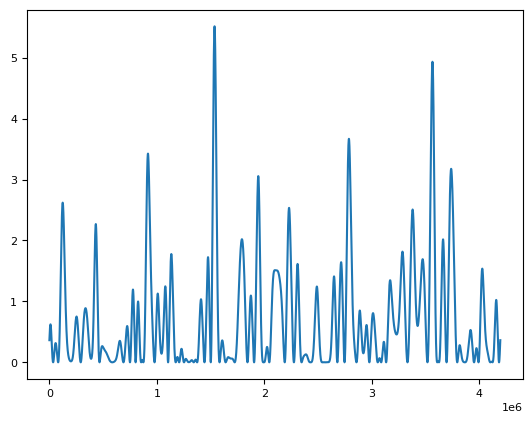

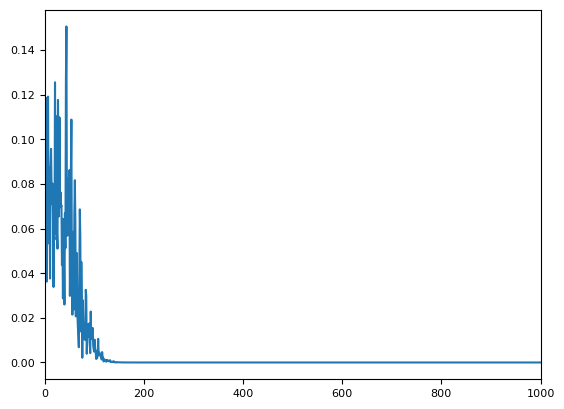

0.7000000000000008
0.7000000000000007


In [6]:
# # Test the asymmetric sinh function applied to a linear function tf
# tf = np.linspace(-4, 4, N)
# zng_asymsinh_test = px.map_asymm_sinh(tf, nu*s1, alpha) - tf


# Generate gaussian distribution from mean and std of NG zeta fields
# ???


# plt.plot(zg)
# plt.show()
plt.plot(zng)
plt.show()

test = np.abs(np.fft.rfft(zng))/N
testk = np.fft.rfftfreq(N) * N
plt.plot(testk[1:], test[1:])
plt.xlim(0, 1000) 
plt.show()

print(test[0])
print(np.mean(zng))

#### Plot the sources

Text(0.94, 0.28, '$\\zeta_{G2}+\\zeta_{NG_1}$')

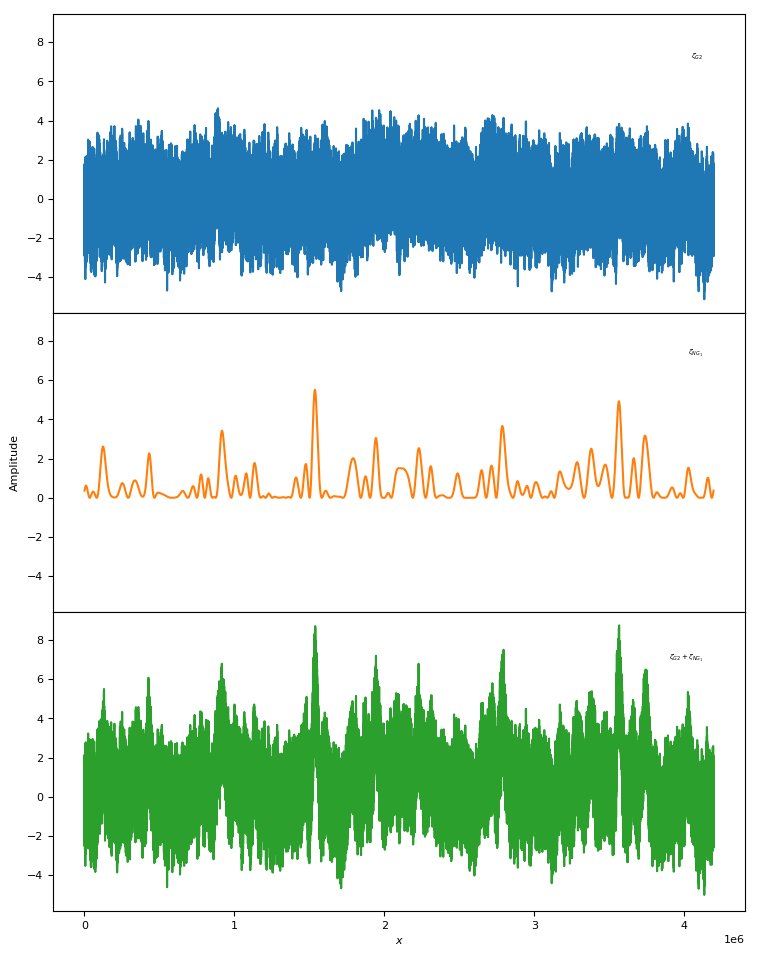

In [7]:
"""
Same plots as above
"""

if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'

fontsize = 5

fig, ax = plt.subplots(3, 1,  sharex=True, sharey=True, figsize=(8,10))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# Original NG component
ax[0].plot(zg)
ax[1].plot(zng, color='C1')
ax[2].plot(zng + zg, color='C2')
ax[2].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.94, 0.95, r'$\zeta_{{{0}}}$'.format(k), fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.62, r'$\zeta_{NG_1}$', fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.28, r'$\zeta_{{{0}}}+\zeta_{{NG_1}}$'.format(k), fontsize=fontsize, horizontalalignment='right')

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

## <u>Apply Filtered ICA to 1D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

#### $\texttt{FastICA}$ test run WITHOUT filtering

In [8]:
"""

Apply ICA

"""

#
#
# ICA parameters/vars
#
#
max_iter = int(5e10)
tol = 1e-13
prewhiten = False
wbin_size = None

#
#
# Run ICA
#
#
src, ica_src, max_amps, mix_signals, ica_src_og = ica.ica_all(zg, zng, 
                                                max_iter=max_iter, tol=tol,
                                                prewhiten = prewhiten, wbin_size = wbin_size)
                                    
mix_signal_pre, mix_signal = mix_signals[0,:], mix_signals[1,:]

(2, 2)


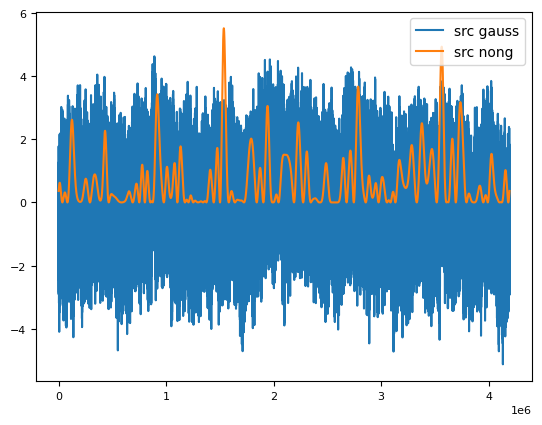

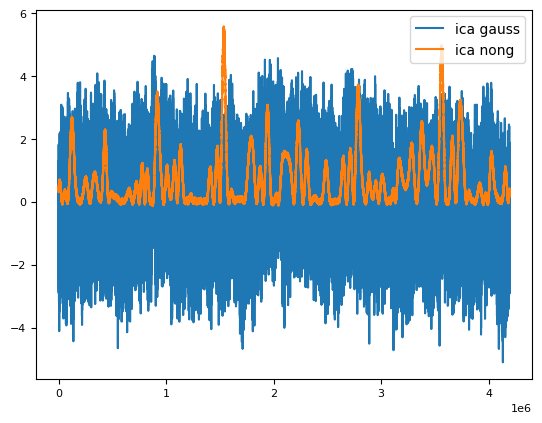

In [9]:
"""

Plot the results

"""

# plt.plot(mix_signal_pre[0, :], label='signal mixture 1')
# plt.legend(loc=1)
# plt.show()

# plt.plot(mix_signal[0, :], label='bin-whitened signal mixture 1')
# plt.legend(loc=1)
# plt.show()


plt.plot(src[1, :], label='src gauss')
plt.plot(src[0, :], label='src nong')
plt.legend(loc=1)
plt.show()

plt.plot(ica_src[1, :], label='ica gauss')
plt.plot(ica_src[0, :], label='ica nong')
plt.legend(loc=1)
plt.show()

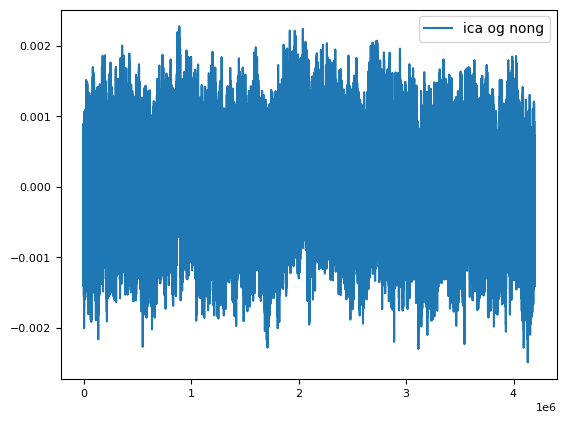

0.38529215509200165


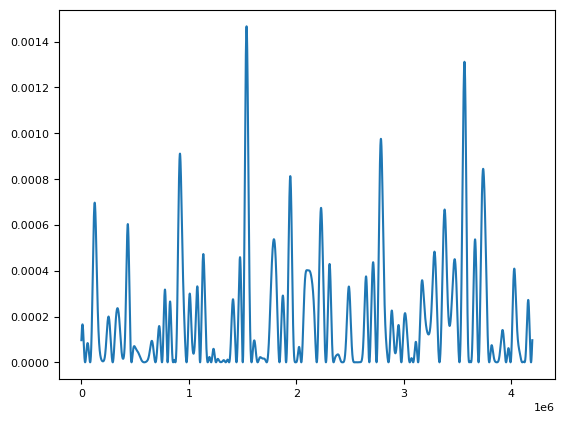

In [10]:
"""

Plot more results

"""

# plt.plot(src[1, :], label='src gauss')
plt.plot(ica_src_og[1, :], label='ica og nong')
plt.legend(loc=1)
plt.show()

a = src[0, :]
b = ica_src[0, :]
rr, rv = resid(a, b)
print(rr)

# a = src[1, :]
# b = ica_src[1, :]
# rv, r, rr = resid(a, b)
# print(r, rr)

plt.plot(rv)
plt.show()

### Apply k-filtered $\texttt{FastICA}$

In [11]:
nkbins = 4
max_iter = int(5e9)
tol = 1e-10
fun='logcosh'
whiten='unit-variance'
algo='parallel'
prewhiten = False
kmin=int(0)
kmin=None
kmax=N//4
kmax=int(100)
kmnr = kmnr
dc=False

src, ica_src, kbins, max_amps, fzkt, zkt, hannf, ica_src_og = flt.filterhann_ica(zg, zng, k_min=kmin, k_max=kmax, kmaxknyq_ratio=kmnr, nkbins=nkbins, dc=dc, 
                                                                max_iter=max_iter, tol=tol, fun='logcosh', whiten='unit-variance', algo='parallel', 
                                                                prewhiten = False)

Processing unfiltered field...
(2, 2)
Swapped!
NonG sign flipped!
[  0  33  67 100]
[  0  33  67 100]
Processing k-bin number:    1 ...
(2, 2)
Swapped!
Processing k-bin number:    2 ...
(2, 2)
NonG sign flipped!
Processing k-bin number:    3 ...
(2, 2)
NonG sign flipped!
Processing k-bin number:    4 ...
(2, 2)
Swapped!
NonG sign flipped!


### Plot the results

#### Source vs. kfICA fig

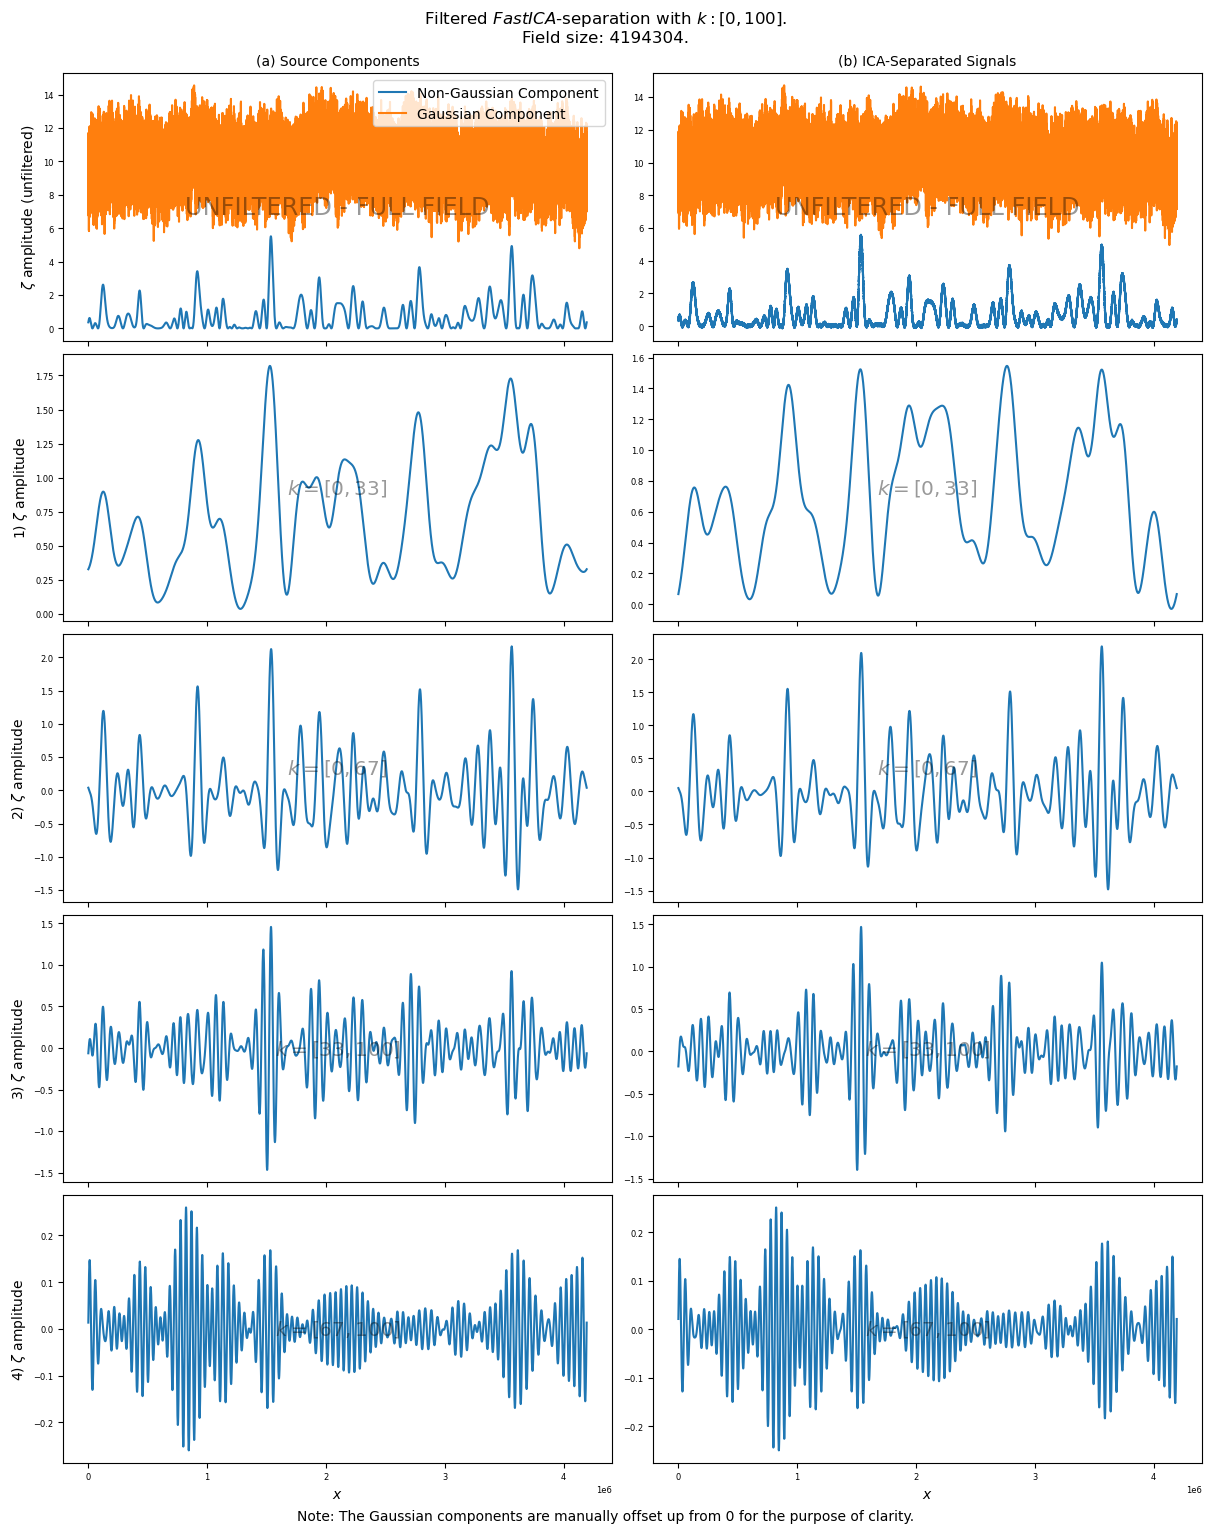

In [12]:
# plt.rcParams.update({'font.size': 12})
helper.plt_icaflt(src, ica_src, kbins, max_amps)

#### Residual plot

0.6147078414846006
0.38529215851539933


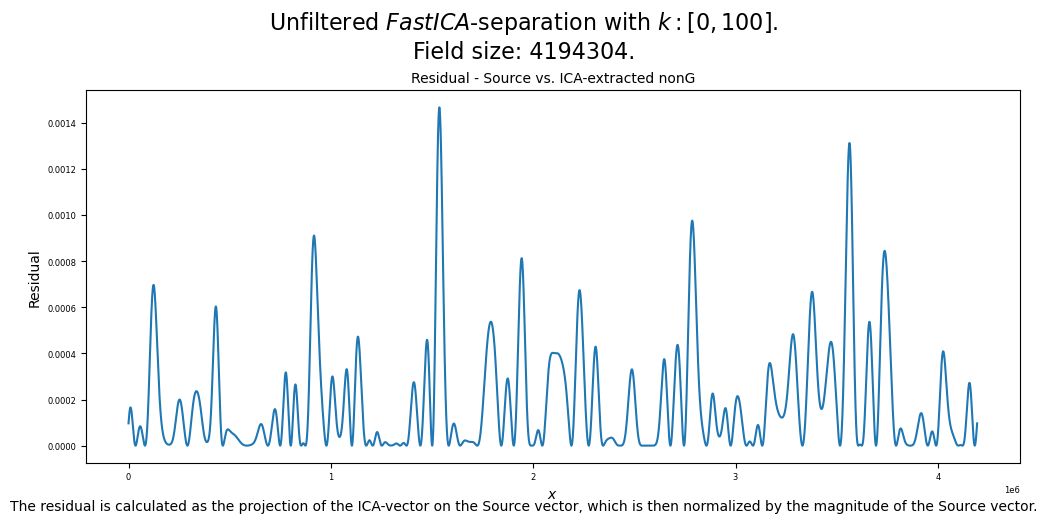

In [13]:
kmin = 0 # TEMPORARY VAR... change this later

srcng_full = src[0, 0, :]
ica_srcng_full = ica_src[0, 0, :]

rr, rv = resid(srcng_full, ica_srcng_full)

rvdotrv = np.dot(rv, rv)
rvmag = np.sqrt(rvdotrv)

print(rvmag)
print(rr)

############
fontsize = 12

fig = plt.figure(figsize=(10,5), constrained_layout=True)
plt.rcParams.update({'font.size': fontsize})

plt.ylabel("Residual")
plt.plot(rv)
plt.xlabel(r'$x$')

plt.title("Residual - Source vs. ICA-extracted nonG")

note="The residual is calculated as the projection of the ICA-vector on the Source vector, which is then normalized by the magnitude of the Source vector."
fig.text(0.5, -0.01, note, wrap=True, horizontalalignment='center', fontsize=10)

fig.suptitle(rf'Unfiltered $\it{{FastICA}}$-separation with $k: [{{{kmin}}}, {{{kmax}}}]$.' + f'\nField size: {N}.', fontsize=16)

plt.savefig(f'/Users/JawanHaider/Desktop/research/research_projects/pnong_ml/ica/figures/icafiltered/chie2/chie2_ica_resid_s{N}_{int(kmin)}to{int(kmax)}k{nkbins}.png', facecolor='white', bbox_inches='tight')

plt.show()

#### TODO: Histogram & CDF comparison

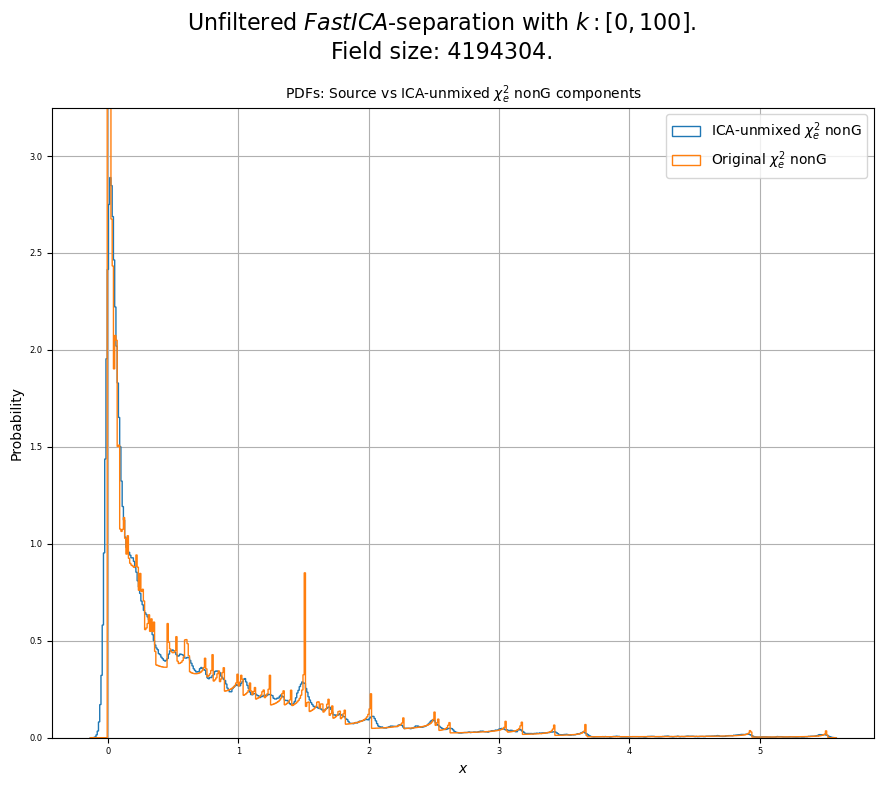

In [14]:
# srcng_full = src[0, 0, :]
# ica_srcng_full = ica_src[0, 0, :]
maxsrcng = srcng_full.max(); minsrcng = srcng_full.min()
maxicang = ica_srcng_full.max(); minicang = ica_srcng_full.min()
histmax = max(maxsrcng, maxicang); histmin = min(minsrcng, minicang)-0.005

hist_binvalues = np.linspace(histmin, histmax, 600)

fig, ax = plt.subplots(1, figsize=(9, 8))
plt.rcParams.update({'font.size': 12})

ax.hist(ica_srcng_full, bins=hist_binvalues, density=True, label=r'ICA-unmixed $\chi^2_e$ nonG', histtype='step')
ax.hist(srcng_full, bins=hist_binvalues, density=True, label=r'Original $\chi^2_e$ nonG', histtype='step', color='C1')

ax.grid(True)
ax.legend()
ax.set_title(r'PDFs: Source vs ICA-unmixed $\chi^2_e$ nonG components')
ax.set(ylabel=r"Probability")
ax.set(xlabel="$x$")
ax.set(ylim=(0,3.25))

fig.suptitle(rf'Unfiltered $\it{{FastICA}}$-separation with $k: [{{{kmin}}}, {{{kmax}}}]$.' + f'\nField size: {N}.', fontsize=16)

plt.savefig(f'/Users/JawanHaider/Desktop/research/research_projects/pnong_ml/ica/figures/icafiltered/chie2/chie2_ica_pdfs_s{N}_{int(kmin)}to{int(kmax)}k{nkbins}.png', facecolor='white', bbox_inches='tight')

fig.tight_layout()
plt.show()

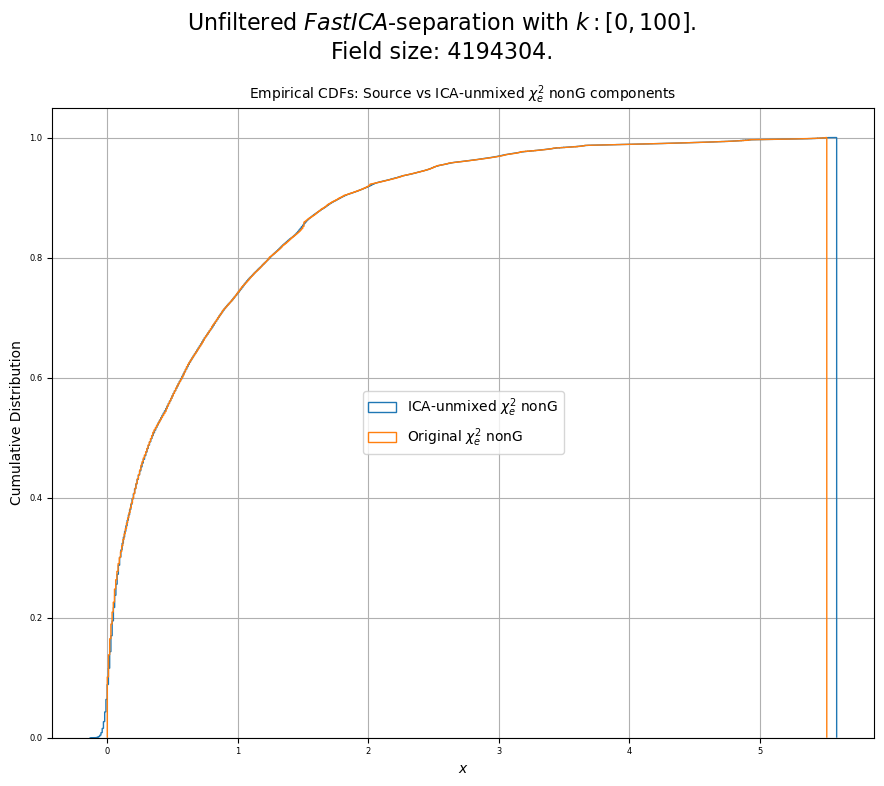

In [15]:


n_bins = 600

fig, ax = plt.subplots(figsize=(9, 8))
plt.rcParams.update({'font.size': 12})

# plot the cumulative histogram
n, bins, patches = ax.hist(ica_srcng_full, n_bins, density=True, histtype='step',
                           cumulative=True, label=r'ICA-unmixed $\chi^2_e$ nonG',)

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
ns, binss, patchess = ax.hist(srcng_full, n_bins, density=True, histtype='step',
                           cumulative=True, label=r'Original $\chi^2_e$ nonG',)

# # Overlay a reversed cumulative histogram.
# ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
#         label='Reversed emp.')

# tidy up the figure
ax.grid(True)
ax.legend(loc='center')
ax.set_title(r'Empirical CDFs: Source vs ICA-unmixed $\chi^2_e$ nonG components')
ax.set_xlabel(r'$x$')
ax.set_ylabel('Cumulative Distribution')

fig.suptitle(rf'Unfiltered $\it{{FastICA}}$-separation with $k: [{{{kmin}}}, {{{kmax}}}]$.' + f'\nField size: {N}.', fontsize=16)

plt.savefig(f'/Users/JawanHaider/Desktop/research/research_projects/pnong_ml/ica/figures/icafiltered/chie2/chie2_ica_cdfs_s{N}_{int(kmin)}to{int(kmax)}k{nkbins}.png', facecolor='white', bbox_inches='tight')

fig.tight_layout()
plt.show()

#### Demonstrate window-filtering

In [16]:
""" 
Original function i'd written to plot kfICA results...

Keeping as backup; function moved to module -- DELETE LATER.
"""
# def plt_filters(N, kc, fzkt, zkt, hannf, fontsize=7):
#     """

#     """

#     fzkt = np.abs(fzkt) / N
#     zkt = np.abs(zkt) / N

#     Nk = fzkt.shape[2]
#     nkbins = fzkt.shape[0]
#     ncomps = fzkt.shape[1]

#     #
#     #
#     # Plot
#     #
#     #
#     plt.rcParams.update({'font.size': fontsize})
#     nrows = nkbins + 1
#     ncols = 2

#     fig, ax = plt.subplots(nrows, 1, sharex='all', figsize=(8, 4*nrows), constrained_layout=True)

#     ax0 = ax[0]
#     for i in range(nkbins):
#         # if i == 0:
#         #     klow = kc[i]
#         #     khigh = kc[i+1]
#         # elif i < nkbins-1:
#         #     klow = kc[i-1]
#         #     khigh = kc[i+1]
#         # else:
#         #     klow = kc[i-1]
#         #     khigh = kc[i]
            
#         if i < nkbins-1:
#             axx = ax[0].twinx()
#             color = 'tab:red'
#             axx.plot(np.nonzero(hannf[i, :])[0], hannf[i, hannf[i, :]!=0], color=color, alpha=0.4)
#             axx.tick_params(axis='y', labelcolor=color)
#             axx.tick_params(
#                 axis='y',           # changes apply to the y-axis
#                 which='both',       # both major and minor ticks are affected
#                 right=False,        # ticks along the right edge are off
#                 labelright=False)   # labels along the right edge are off
#         else:
#             axx = ax[0].twinx()
#             color = 'tab:red'
#             label = "Hann window"
#             axx.plot(hannf[i, :], label=label, color=color, alpha=0.4)
#             axx.tick_params(axis='y', labelcolor=color)
#             axx.set_ylabel('Window Amplitude', color=color)
#             axx.legend(loc=1)
    
#     ax[0].set_title("Unfiltered k-frequencies with Hann")
#     label = "k-frequencies"
#     ax[0].plot(zkt[0, :], label=label)
#     ax[0].set(ylabel="k-amplitude (unfiltered)")
#     ax[0].legend(loc=2)

#     ax[0].text(0.5, 0.5, "UNFILTERED K-FREQUENCIES", 
#                     fontsize='xx-large', transform=ax[0].transAxes, 
#                         ha='center', va='center', alpha=0.4)

#     ax[1].set_title("Filtered k-frequencies with Hann")
#     for i in range(nkbins):
#         count = i+1
#         if i == 0:
#             klow = kc[i]
#             khigh = kc[i+1]
#         elif i < nkbins-1:
#             klow = kc[i-1]
#             khigh = kc[i+1]
#         else:
#             klow = kc[i-1]
#             khigh = kc[i]

#         klow = round(klow, 0); khigh = round(khigh, 0)


#         axx = ax[count].twinx()
#         color = 'tab:red'
#         axx.set_ylabel('Window Amplitude', color=color)
#         label = "Hann window"
#         axx.plot(hannf[i, :], label=label, color=color)
#         axx.tick_params(axis='y', labelcolor=color)
#         axx.legend(loc=1)

#         # ax[count, 0].sharey(ax00)
#         label = "k-frequencies"
#         ax[count].plot(fzkt[i, 0, :], label=label)
#         ax[count].set(ylabel=f'{count}) ' + "k amplitude with filter: " + r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh))
#         ax[count].legend(loc=2)
        

#         ax[count].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
#                                 fontsize='xx-large', transform=ax[count].transAxes, 
#                                     ha='center', va='center', alpha=0.4)

#     ax_count = nkbins
#     ax[ax_count].set(xlabel=r'$k$')

#     fig.suptitle(rf'Hann window-filtering in Fourier-domain with $k: [{{{kc[0]}}}, {{{kc[-1]}}}]$.' + f'\nField size: {N}.', fontsize=16)

#     plt.savefig(f'/fs/lustre/cita/haider/projects/pnong_ml/ica/plots/icafiltered/chie2/chie2_hann_s{N}_{int(kbins[0])}to{int(kbins[-1])}k{nkbins}.png', facecolor='white', bbox_inches='tight')
#     # note="Note: The Gaussian components are manually offset up from 0 for the purpose of clarity."
#     # fig.text(0.5, -0.01, note, wrap=True, horizontalalignment='center', fontsize=8)
#     plt.show()

#     return

" \nOriginal function i'd written to plot kfICA results...\n\nKeeping as backup; function moved to module -- DELETE LATER.\n"

[  0  33  67 100]
(4, 2, 100)
/Users/JawanHaider/Desktop/research/research_projects/pnong_ml/ica


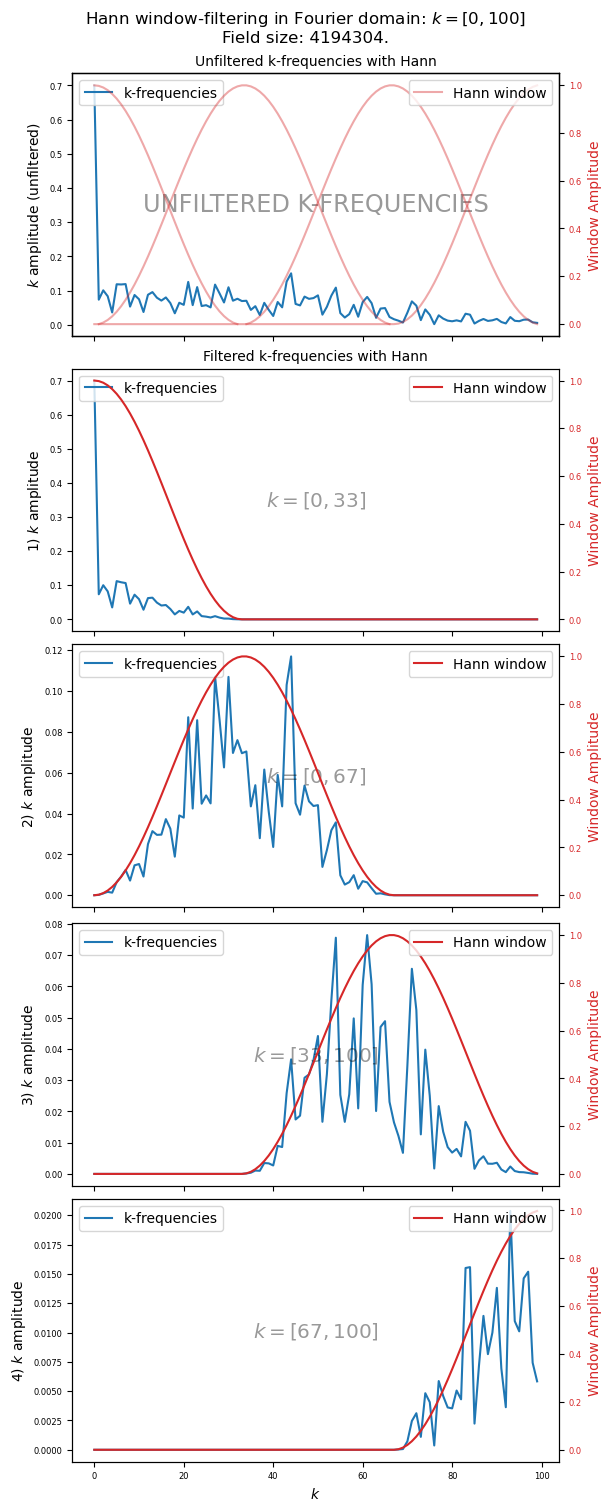

In [17]:
"""Plot each filter and show what it gives us.

"""

print(kbins)
print(fzkt.shape)
# print(np.abs(fzkt[9, 0, 222:230])/N)
# print(hannf[9, 222:230])
helper.plt_filters(N, kbins, fzkt, zkt, hannf)

## Tests

In [18]:
# f = 1
# xmax = 10
# s = 1000
# x = np.linspace(0, xmax, int(xmax*s))
# # y = np.sin(2 * np.pi * f * x)
# y = np.sin(2 * np.pi * f * x)+1
# print(y.size)
# testft = np.fft.rfft(y)
# testft[0] = 0
# testftabs = np.abs(np.fft.rfft(y))
# testftfreq = np.fft.rfftfreq(y.size, d=1./s)
# iy = np.fft.irfft(testft, len(y))
# print(iy.size)
# print(testftfreq.size)
# plt.plot(x, y)
# plt.show()
# plt.plot(testftfreq, testftabs)
# plt.xlim(0,10)
# plt.show()
# plt.plot(x, iy)
# plt.show()

In [19]:
# n = 100
# h1, h2, h3 = 0, 50, 100
# domain = np.arange(0, n)

# hann1 = np.zeros(n)
# hann2 = np.zeros(n)
# hann3 = np.zeros(n)

# hann1[h1:h2] = hann(n, False)[h2:h3]
# hann2[h1:h3] = hann(n, False)
# hann3[h2:h3] = hann(n, False)[h1:h2]
# hannsum = hann1+hann2+hann3

In [20]:
# print(hann2.size)
# print(hann2[-1])
# print(hann2)

In [21]:
# plt.scatter(domain, hann1)
# plt.scatter(domain, hann2)
# plt.scatter(domain, hann3)
# plt.scatter(domain, hannsum)

In [22]:
# npks = 50
# npkshk = int(100)

# w = 0.01
# whk = w/500

# xrange = 40
# n = 500000
# samplerate = xrange/n

# aPeak1 = np.full(npks, 7)
# aPeak2 = np.full(10, 10)
# aPeak3 = np.full(npkshk, 5)

# xPeak1 = np.linspace(-10, 10, npks)
# xPeak2 = np.linspace(-10, 10, 4)
# xPeak3 = np.linspace(-10, 10, npkshk)

# wPeak1 = np.full(npks, w)
# wPeak2 = np.full(5, w*20)
# wPeak3 = np.full(npkshk, whk)

# rv = np.linspace(-10, 10, n)
# pks1 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak1,xPeak1,wPeak1)]), axis=0) # Peaks as separate source signals
# pks2 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak2,xPeak2,wPeak2)]), axis=0) # Peaks as separate source signals
# pks3 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak3,xPeak3,wPeak3)]), axis=0) # Peaks as separate source signals
# tst = np.sum([pks1, pks2, pks3], axis=0) # Peaks as separate source signals
# x = np.linspace(0, xrange, n)

# plt.plot(x, tst)
# plt.show()

# tstfft = np.abs(np.fft.rfft(tst))
# tstk = np.fft.rfftfreq(n, d=1./samplerate)*n

# plt.plot(tstk[4:], (tstfft/n)[4:])
# # plt.xlim(0.01, 5)
# plt.show()

In [23]:
# yy = np.fft.irfft(tstfft)

In [24]:
# plt.plot(x, yy)
# plt.show()

In [25]:
# filtt, k, _, _, _ = flt.filter_hann(tst, 3)
# print(filtt.shape)
# abc = np.sum(filtt, axis=0)
# # plt.plot(x, filtt[2, :])
# plt.plot(x, abc)

In [26]:
# k = 1.5
# x = np.linspace(-1.0, 1.0, 500)
# # print(x)
# # tanharg = np.where(x != 1.0, k*x / ( np.sqrt(1 - x**2) ), 0)
# tanharg = k*x / ( np.sqrt(1 - x**2) )
# # print(tanharg)
# winl_tanh = (np.tanh(tanharg) + 1) / 2
# winr_tanh = (-np.tanh(tanharg) + 1) / 2
# win_tanh = np.concatenate((winl_tanh, winr_tanh))
# # print(win_tanh)

In [27]:
# plt.plot(win_tanh)

In [28]:
# M = 51
# hanntest = hann(M)
# plt.plot(hanntest)
# plt.show()

# from scipy.fft import fft, fftshift

# print(len(hanntest))
# A = fft(hanntest, 2048) / (len(hanntest))
# print(A.size)
# freq = np.linspace(-0.5, 0.5, len(A))
# response = np.abs(fftshift(A / abs(A).max()))

# z = np.zeros(51)
# hanntestfft = np.concatenate((hann(M), z))
# plt.plot(hanntestfft)
# plt.show()
# hanntest = np.abs(np.fft.irfft(hanntestfft))
# # hannfftk = np.fft.fftfreq(M) * M

# plt.plot(hanntest)
# # plt.plot(freq, response)
# plt.show()

In [29]:
# 